In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd

from os import listdir, mkdir, getcwd
from os.path import isfile, join, basename, isdir

from sys import platform
#if platform == "linux" or platform == "linux2":
#    import ROOT
#    %jsroot off

from analysis.convert_directory import convert_directory

In [2]:
source_path = getcwd() # "/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH/"
output_path = join(source_path, ".npy")

convert_directory(source_path, "dataTree", output_path)

Skipping file <compare_out.root> (exists)
Skipping file <compare_out_jet.root> (exists)
Skipping file <compare_out_mcparticle.root> (exists)


In [71]:
# Splits a dataframe with separate columns for reco and true properties to one with the properties and a different label "type" with values "true" and "reco" 
def split_event_tree(df,
                     properties=["sigma", "nll"],
                     props_shared=["run", "event", "is_zhh", "is_zzh", "h1z2_decay_pdg", "llr"],
                     type_names=["zhh", "zzh"],
                     ttype_cols=["is_zhh", "is_zzh"], # true type columns
                     column_concat: str ="_"):
    #type_dict = {}
    #for property in properties:
    #    type_dict[property] = pd.Series(dtype=df.dtypes[type_names[0] + column_concat + property])

    # Rename
    rename_dict = {}
    for property in properties:
        rename_dict[type_names[0] + column_concat + property] = property

    df = df.rename(columns=rename_dict)
    df["mem_type"] = type_names[0]

    # Slice and re-add
    for type in type_names:
        if type == type_names[0]:
            continue

        #column_names = [word.replace(type + column_concat, "") for word in ["asd_123", "asd_345"]]
        props_type_specific = list(map(lambda cn: type+column_concat+cn, properties))
        props_slice = props_shared + props_type_specific
        sliced = df.loc[:, props_slice]

        df.drop(columns=props_type_specific, inplace=True)

        rename_dict = {}
        for property in properties:
            rename_dict[type + column_concat + property] = property

        sliced.rename(columns=rename_dict, inplace=True)
        sliced["mem_type"] = type        

        df = pd.concat([df, sliced])

    # Apply true_type column
    condlist = []

    for col in ttype_cols:
        condlist.append(df[col].bool())

    df[:, "true_type"] = np.select(condlist, type_names, default="none")

    df.reset_index(drop=True, inplace=True)

    return df

def ttype_column(df, column="true_type", type_names = ["zhh", "zzh"], check = ["is_zhh", "is_zzh"]):
    condlist = []
    for col in check:
        condlist.append(df[col].astype(bool))

    df[column] = np.select(condlist, type_names, default="none")
    df.reset_index(drop=True, inplace=True)

    return df

In [73]:
b = list(map(lambda e: join(output_path, e), listdir(output_path)))
b

['c:\\DevRepositories\\MEM_HEP\\.npy\\compare_out.root.npy',
 'c:\\DevRepositories\\MEM_HEP\\.npy\\compare_out_jet.root.npy',
 'c:\\DevRepositories\\MEM_HEP\\.npy\\compare_out_mcparticle.root.npy']

In [78]:
data = pd.DataFrame(np.load(b[1], allow_pickle=True))
ttype_column(data)
data.columns

Index(['run', 'event', 'is_zhh', 'is_zzh', 'h1_decay_pdg', 'z2_decay_pdg',
       'zhh_sigma', 'zhh_sigmall', 'zhh_sigmalr', 'zhh_sigmarl', 'zhh_sigmarr',
       'zhh_mz', 'zhh_mhh', 'zhh_mzhh', 'zhh_phi', 'zhh_phif', 'zhh_phih',
       'zhh_costheta', 'zhh_costhetaf', 'zhh_costhetah', 'zhh_l1_e',
       'zhh_l1_px', 'zhh_l1_py', 'zhh_l1_pz', 'zhh_l2_e', 'zhh_l2_px',
       'zhh_l2_py', 'zhh_l2_pz', 'zhh_h1_e', 'zhh_h1_px', 'zhh_h1_py',
       'zhh_h1_pz', 'zhh_h2_e', 'zhh_h2_px', 'zhh_h2_py', 'zhh_h2_pz',
       'zzh_sigma', 'zzh_sigmalll', 'zzh_sigmallr', 'zzh_sigmalrl',
       'zzh_sigmalrr', 'zzh_sigmarrr', 'zzh_sigmarrl', 'zzh_sigmarlr',
       'zzh_sigmarll', 'zzh_mz1', 'zzh_mz2', 'zzh_mzz', 'zzh_mzzh', 'zzh_phi',
       'zzh_phiz', 'zzh_phiz1f', 'zzh_phiz2f', 'zzh_costheta', 'zzh_costhetaz',
       'zzh_costhetaz1f', 'zzh_costhetaz2f', 'zzh_l1_e', 'zzh_l1_px',
       'zzh_l1_py', 'zzh_l1_pz', 'zzh_l2_e', 'zzh_l2_px', 'zzh_l2_py',
       'zzh_l2_pz', 'zzh_z2f1_e', 'zzh_z2f1_px', 

In [79]:
data.dtypes

run               int32
event             int32
is_zhh            int32
is_zzh            int32
h1_decay_pdg      int32
                 ...   
zzh_h_e         float64
zzh_h_px        float64
zzh_h_py        float64
zzh_h_pz        float64
true_type        object
Length: 78, dtype: object

In [80]:
data["h1z2_decay_pdg"] = data["h1_decay_pdg"] + data["z2_decay_pdg"]

Text(0.5, 1.0, 'MCParticle data')

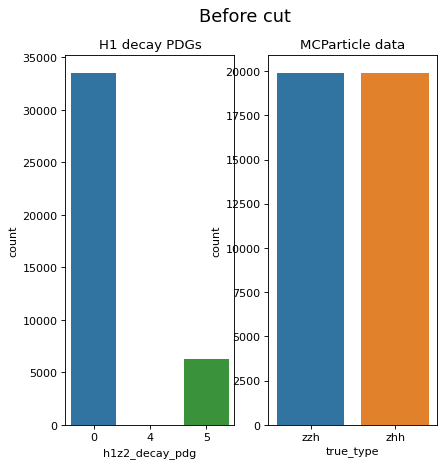

In [112]:
d = data
fig, axes = plt.subplots(1,2, figsize=(6, 6), dpi=80)
fig.suptitle("Before cut", fontsize=16)

ax = sns.countplot(d, x="h1z2_decay_pdg", ax=axes[0])
ax.set_title("H1 decay PDGs")

ax = sns.countplot(d, x="true_type", ax=axes[1])
ax.set_title("MCParticle data")

Important: Unaccounted/"thrown away" events: H->gg,gammagamma,ZZ,W+W-

In [113]:
# Show amount of thrown-away entries
selection = data[(data["zhh_sigma"] <= 0) | (data["zzh_sigma"] <= 0)]
print("Throwing away", len(selection)/len(data)*100, "% of all events")

Throwing away 84.23115577889448 % of all events


In [114]:
# Applying cut
data_cut = data.loc[(data["zhh_sigma"] > 0) & (data["zzh_sigma"] > 0)].copy()
data_cut.shape

(6276, 79)

In [126]:
data_cut["zhh_nll"] = np.log(data_cut["zhh_sigma"])
data_cut["zzh_nll"] = np.log(data_cut["zzh_sigma"])
data_cut["llr"]     = np.log(data_cut["zzh_sigma"]/data_cut["zhh_sigma"])
data_cut.reset_index(drop=True, inplace=True)

Text(0.5, 0, 'ln(L_0/L_1)')

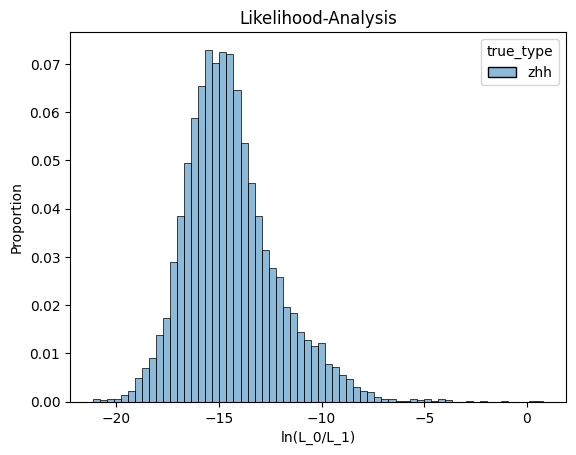

In [133]:
ax = sns.histplot(data_cut, x="llr", hue="true_type", bins=64, stat="proportion")
ax.set_title("Likelihood-Analysis")
ax.set_xlabel("ln(L_0/L_1)")

Text(0.5, 1.0, 'ZHH vs ZZH LR')

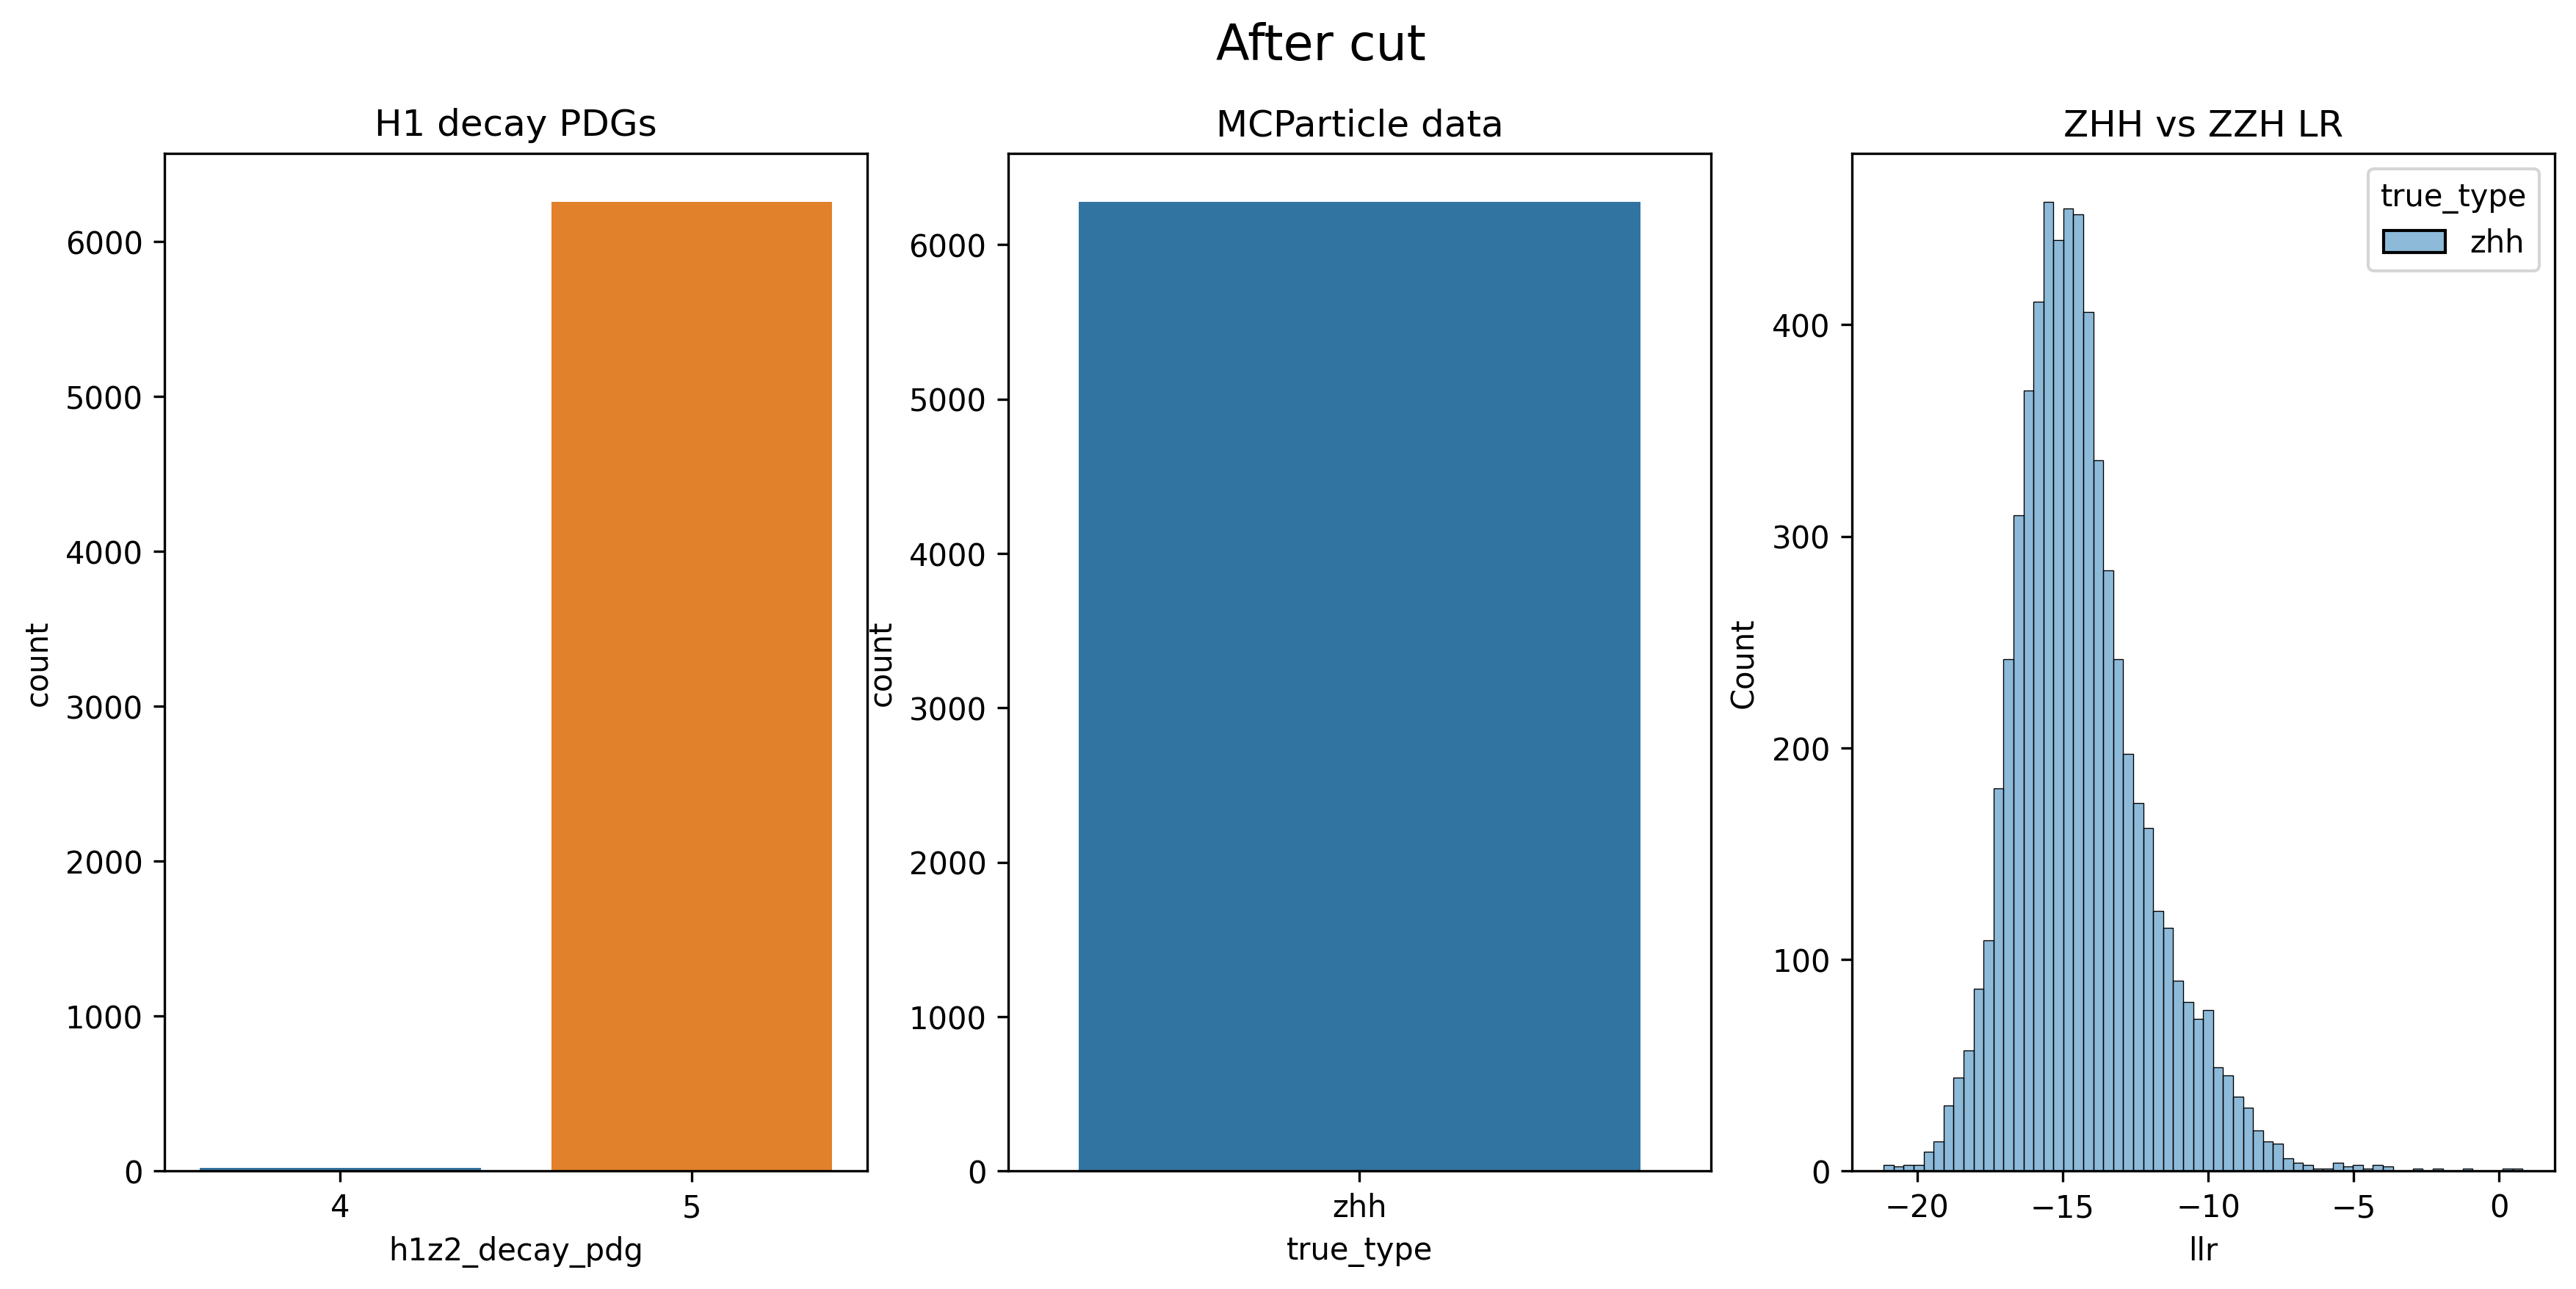

In [134]:
d = data_cut
fig, axes = plt.subplots(1,3, figsize=(14, 6), dpi=300)
fig.suptitle("After cut", fontsize=16)

ax = sns.countplot(d, x="h1z2_decay_pdg", ax=axes[0])
ax.set_title("H1 decay PDGs")

ax = sns.countplot(d, x="true_type", ax=axes[1])
ax.set_title("MCParticle data")

ax = sns.histplot(d, x="llr", hue="true_type", bins=64, ax=axes[2])
ax.set_title("ZHH vs ZZH LR")

In [123]:
true_zhh = data_cut[data_cut["is_zhh"] == 1]
true_zzh = data_cut[data_cut["is_zzh"] == 1]

In [124]:
print(true_zhh.shape[0], true_zzh.shape[0])

6276 0


In [136]:
true_zhh_split = split_event_tree(true_zhh)
true_zzh_split = split_event_tree(true_zzh)

Text(0.5, 1.0, 'True ZHH MCParticles')

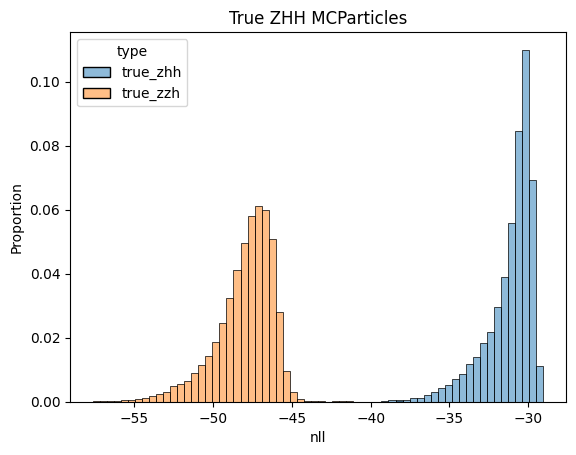

In [197]:
ax = sns.histplot(true_zhh_split, x="nll", hue="true_type", bins=64, stat="proportion")
ax.set_title("True ZHH MCParticles")

In [204]:
true_zzh_split.reset_index(drop=True, inplace=True)
true_zzh_split

,run,event,true_is_zhh,true_is_zzh,true_h1_decay_pdg,true_z2_decay_pdg,sigma,true_zhh_sigmall,true_zhh_sigmalr,true_zhh_sigmarl,...,true_zzh_z2f2_py,true_zzh_z2f2_pz,true_zzh_h_e,true_zzh_h_px,true_zzh_h_py,true_zzh_h_pz,true_h1z2_decay_pdg,nll,true_llr,type
0,403011,1,0,1,0.0,3.0,7.344602e-14,6.965651e-14,3.789516e-15,3.805584e-15,...,46.695015,124.031075,157.041733,72.794846,-53.599247,-29.413172,3,-30.242226,-12.641044,true_zhh
1,403011,2,0,1,0.0,3.0,4.030331e-15,3.575435e-15,4.548957e-16,4.571881e-16,...,-12.769003,11.577676,207.198273,-61.250061,-57.741375,142.198761,3,-33.144928,-13.411046,true_zhh
2,403011,3,0,1,0.0,4.0,5.704280e-14,2.816861e-14,2.887418e-14,2.887788e-14,...,-27.447758,0.089793,131.937668,35.247631,13.085950,19.206999,4,-30.494975,-9.337396,true_zhh
3,403011,4,0,1,0.0,4.0,5.946260e-15,1.461537e-15,4.484724e-15,4.473190e-15,...,32.319328,-30.268082,220.370789,23.868135,-177.702896,-28.111895,4,-32.756014,-11.228584,true_zhh
4,403011,5,0,1,0.0,5.0,1.256231e-14,1.136108e-14,1.201230e-15,1.202365e-15,...,-85.247139,61.523773,139.716232,12.830882,56.313324,-23.660160,5,-32.008075,-16.234907,true_zhh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,403011,19896,0,1,NaN,NaN,2.275090e-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,-40.624512,-10.832258,true_zzh
39796,403011,19897,0,1,NaN,NaN,6.323993e-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,-44.207351,-11.126942,true_zzh
39797,403011,19898,0,1,NaN,NaN,2.782756e-22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,-49.633430,-10.867312,true_zzh
39798,403011,19899,0,1,NaN,NaN,6.431234e-19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,-41.887950,-11.220890,true_zzh


Text(0.5, 1.0, 'True ZZH MCParticles')

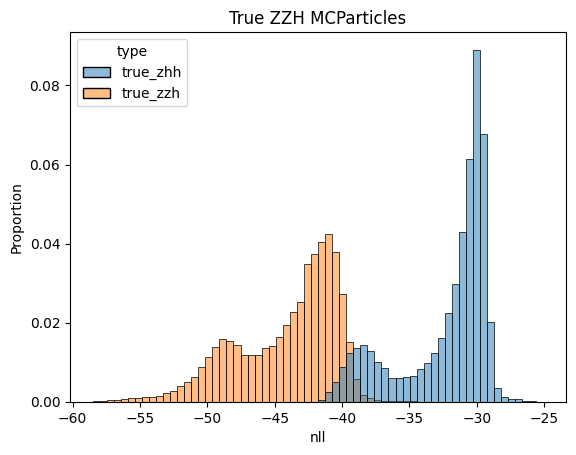

In [198]:
ax = sns.histplot(true_zzh_split, x="nll", hue="type", bins=64, stat="proportion")
ax.set_title("True ZZH MCParticles")